In [1]:
%matplotlib inline
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime
from collections import defaultdict
from scipy.stats import skew, kurtosis
import time

# sklearn
from sklearn. metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,Normalizer,QuantileTransformer,PowerTransformer


from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# mpl_finance
#from mpl_finance import candlestick2_ohlc

# decimal
from decimal import ROUND_HALF_UP, Decimal

# warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data

folder_list = os.listdir('../input/jpx-tokyo-stock-exchange-prediction/')
for idx,ls in enumerate(folder_list):
    print(str(idx) + ':' + ls)
    
def load_file(folder):
    folder_dir = '../input/jpx-tokyo-stock-exchange-prediction/'
    
    if folder == 'stock_list.csv':
        globals()['{}'.format(folder[:-4])] = pd.read_csv(folder_dir+'/'+folder)
        return folder
        
    files = os.listdir(folder_dir+folder)
    
    for f in tqdm(files):
        if 'csv' in f:
            f_ = f[:-4]
        globals()['{}_{}'.format(folder,f_)] = pd.read_csv(folder_dir+'/'+folder+'/'+f)
        print('{}_{}'.format(folder,f_))

0:example_test_files
1:stock_list.csv
2:jpx_tokyo_market_prediction
3:data_specifications
4:train_files
5:supplemental_files


In [3]:
# train_files - train set
load_file(folder_list[4])
# example_test_files - test set
load_file(folder_list[0])
# stock_list - merge data set
load_file(folder_list[1])
# supplemental - validation set
load_file(folder_list[5])

 20%|██        | 1/5 [00:23<01:32, 23.07s/it]

train_files_options


 40%|████      | 2/5 [00:24<00:30, 10.33s/it]

train_files_financials


 60%|██████    | 3/5 [00:30<00:16,  8.47s/it]

train_files_secondary_stock_prices
train_files_trades


100%|██████████| 5/5 [00:37<00:00,  7.40s/it]


train_files_stock_prices


100%|██████████| 6/6 [00:00<00:00, 37.75it/s]


example_test_files_sample_submission
example_test_files_options
example_test_files_financials
example_test_files_secondary_stock_prices
example_test_files_trades
example_test_files_stock_prices


 40%|████      | 2/5 [00:03<00:03,  1.30s/it]

supplemental_files_options
supplemental_files_financials


 60%|██████    | 3/5 [00:03<00:01,  1.01it/s]

supplemental_files_secondary_stock_prices
supplemental_files_trades


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

supplemental_files_stock_prices


In [4]:
train_df_copy = train_files_stock_prices.copy()
test_df_copy = example_test_files_stock_prices.copy()
supplemental_df_copy = supplemental_files_stock_prices.copy()

Adjusted Close

https://psystat.tistory.com/158

https://joshschertz.com/2016/08/27/Vectorizing-Adjusted-Close-with-Python/

AutoEncoder

https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

Sliding Window LSTM

https://www.kaggle.com/code/hechtjp/jpx-keras-stacking-lstm-beginner

https://www.tradewithscience.com/stock-split-adjusting-with-python/
https://www.kaggle.com/code/onurkoc83/calc-of-adjusted-close
https://www.kaggle.com/code/vweimer/jpx-adjusted-close-and-volume-and-features
https://www.kaggle.com/code/kotaromiura/jpx-lgbm-demo

# Adjust_Price

In [5]:
#train_df_copy.ExpectedDividend = train_df_copy.ExpectedDividend.fillna(0.0)

In [6]:
def calculate_adjusted_prices_iterative(df:pd.DataFrame(), column:str = 'Close'):
    adj_column = 'Adj_' + column

    df.sort_values(by = 'Date', ascending = False, inplace = True)

    price_col = df[column].values
    split_col = df['AdjustmentFactor'].values
    dividend_col = df['ExpectedDividend'].values
    adj_price_col = np.zeros(len(df.index))
    adj_price_col[0] = price_col[0]
    
    for i in range(1, len(price_col)):
        adj_price_col[i] = round((adj_price_col[i - 1] + adj_price_col[i - 1] * (((price_col[i] * split_col[i - 1]) - price_col[i - 1] - dividend_col[i - 1]) / price_col[i - 1])), 4)

    df[adj_column] = adj_price_col
    df.sort_values(by = 'Date', ascending = True, inplace = True)

    return df
    
def generate_adjusted_close(df:pd.DataFrame()):
    df = df.sort_values("Date", ascending=False)
    df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
    df.loc[:, "Adj_Close"] = (df["CumulativeAdjustmentFactor"] * df["Close"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)))
    df = df.sort_values("Date")
    df.loc[df["Adj_Close"] == 0, "Adj_Close"] = np.nan
    df.loc[:, "Adj_Close"] = df.loc[:, "Adj_Close"].ffill()
    return df

def generated_adjusted_price(df:pd.DataFrame()):
    df = df.sort_values('Date', ascending = False)
    df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
    adjusted_df = df.copy()
    for price in ['Open', 'High', 'Low', 'Close']:
        adjusted_df[price] *= adjusted_df['CumulativeAdjustmentFactor']
    adjusted_df['Volume'] /= adjusted_df['CumulativeAdjustmentFactor']
    return df

def generate_adjusted_closevol(df:pd.DataFrame()):
    df = df.sort_values('Date', ascending=False)
    df.loc[:, 'CumAdjustmentFactor'] = df['AdjustmentFactor'].cumprod()
    df.loc[:, 'Adj_Close'] = (df['Close'] * df['CumAdjustmentFactor']).map(lambda x: float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)))
    df = df.sort_values('Date')
    df.loc[:, 'CumAdjustmentFactorVol'] = df['AdjustmentFactor'].cumprod()
    df['Adj_Volume'] = df['Volume'].where(df['AdjustmentFactor'] != 1, (df['Volume'] * df['CumAdjustmentFactorVol']).astype('int64'))
    return df

def calculate_adjusted(df:pd.DataFrame(), dividends=False):
        
    df.sort_values(by = 'Date', ascending=False, inplace = True)

    split_coef = df['AdjustmentFactor'].shift(1).fillna(1).cumprod()

    for col in ['Open', 'High', 'Low', 'Close']:
        df['Adj_' + col] = df[col] / split_coef
    df['Adj_Volume'] = split_coef * df['Volume']

    if dividends:
        df['adj_dividends'] = df['dividend amount'] / split_coef

    df.sort_values(by = 'Date', ascending=True, inplace = True)
        
    return df

# Get_Indicator

In [7]:
def get_Indicator(df:pd.DataFrame(), indicator):
    
    df.loc[: ,"Date"] = pd.to_datetime(df.loc[: ,"Date"], format="%Y-%m-%d")
    df.sort_values(by = ['SecuritiesCode', 'Date'], inplace = True)
    df = df.groupby(['SecuritiesCode']).apply(indicator).reset_index(drop = True)
    
    df.set_index('Date', inplace = True)
    return df

# Sharpe Ratio

In [8]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Prediction'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Prediction'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

def cal_sharpe_ratio(df):
    
    def first200(df):
          return pd.DataFrame(-np.sort(-df["Prediction"])[:200-1]).T
    first200 = df.groupby('Date').apply(first200)

    def last200(df):
          return pd.DataFrame(np.sort(df["Prediction"])[0:200-1]).T
    last200 = df.groupby('Date').apply(last200)

    weights = np.linspace(start=2, stop=1, num=200)

    Sup=((first200 * weights).sum(axis = 1))/np.mean(weights)
    Sdown=((last200 * weights).sum(axis = 1))/np.mean(weights)
    
    daily_spread_returns = (Sup - Sdown)
    sharpe_ratio = (Sup - Sdown).mean()/(Sup - Sdown).std()
    
    return sharpe_ratio

In [9]:
train_df_copy['Date'] = pd.to_datetime(train_df_copy['Date'])
supplemental_df_copy['Date'] = pd.to_datetime(supplemental_df_copy['Date'])

train_df_copy = pd.concat([train_df_copy, supplemental_df_copy], axis = 0)#.reset_index(drop = True)

In [10]:
#train_df_copy = get_Indicator(train_df_copy, calculate_adjusted_prices_iterative)
#train_df_copy = get_Indicator(train_df_copy, generate_adjusted_close)
#train_df_copy = get_Indicator(train_df_copy, generate_adjusted_closevol)
train_df_copy = get_Indicator(train_df_copy, calculate_adjusted)
#train_df_copy = get_Indicator(train_df_copy, generated_adjusted_price)

In [11]:
train_df_copy.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,2734.0,2755.0,2730.0,2742.0,31400.0
2017-01-05,20170105_1301,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,2743.0,2747.0,2735.0,2738.0,17900.0
2017-01-06,20170106_1301,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,2734.0,2744.0,2720.0,2740.0,19900.0
2017-01-10,20170110_1301,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,2745.0,2754.0,2735.0,2748.0,24200.0
2017-01-11,20170111_1301,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,2748.0,2752.0,2737.0,2745.0,9300.0


In [12]:
#listfeatures = ['Open', 'High', 'Low', 'Close','Volume']
#listfeatures = ['Adj_Close', 'Open', 'High', 'Low', 'Close','Volume']
#listfeatures = ['Adj_Close', 'Adj_Volume', 'Open', 'High', 'Low', 'Close','Volume']
#listfeatures = ['Adj_Close', 'Adj_Open', 'Adj_High', 'Adj_Low', 'Open', 'High', 'Low', 'Close', 'Volume']
#listfeatures = ['Adj_Close', 'Adj_Open', 'Adj_High', 'Adj_Low', 'Adj_Volume', 'Open', 'High', 'Low', 'Close', 'Volume']
#listfeatures = ['Adj_Close', 'Adj_Open', 'Adj_High', 'Adj_Low', 'Adj_Volume']
listfeatures = ['Adj_Close', 'Adj_Open', 'Adj_High', 'Adj_Low']
#listfeatures = ['Adj_Close']
#listfeatures = ['Adj_Close', 'Adj_Volume']

# transform log1p
train_df_copy[listfeatures] = train_df_copy[listfeatures].apply(np.log1p)

# transform MinMaxScale
scaler = MinMaxScaler()
train_df_copy[listfeatures] = scaler.fit_transform(train_df_copy[listfeatures])

In [13]:
train_df_copy.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,0.590493,0.589127,0.593621,0.591342,31400.0
2017-01-05,20170105_1301,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,0.590762,0.588888,0.593770,0.591223,17900.0
2017-01-06,20170106_1301,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,0.590493,0.588799,0.593323,0.591282,19900.0
2017-01-10,20170110_1301,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,0.590821,0.589097,0.593770,0.591520,24200.0
2017-01-11,20170111_1301,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,0.590910,0.589038,0.593830,0.591431,9300.0


In [14]:
def window_sequences(df:pd.DataFrame(), window:int, window_type:'basic', target_size:int=1):
    listsc = df.SecuritiesCode.unique().tolist()
    X = []
    Y = []
    start_idx = 0
    
    for sc in tqdm(listsc):
        dfTemp = df[df.SecuritiesCode == sc]
        
        dfTemp = dfTemp.interpolate()
        #dfTemp = dfTemp.dropna(how = 'any')
        dfTemp = dfTemp.bfill().ffill()
        #dfTemp = dfTemp.fillna(0)
        
        iterN = (dfTemp.shape[0] - window + target_size)
    
        if window_type == 'expansion':
            
            for i in range(iterN):
                x = dfTemp[listfeatures].iloc[start_idx:(i + window)].to_numpy()
                y = dfTemp.Target.iat[(i + window - target_size)].reshape([1, 1])
            
        else:
            
            for i in range(iterN):
                x = dfTemp[listfeatures].iloc[start_idx + i:(i + window)].to_numpy()
                y = dfTemp.Target.iat[(i + window - target_size)].reshape([1, 1])
            
        X.append(x)
        Y.append(y)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [15]:
# 8Days Sliding
#X_8, y_8 = window_sequences(train_df_copy, 8, window_type = 'basic')

# 16Days Sliding
#X_16, y_16 = window_sequences(train_df_copy, 16, window_type = 'basic')

# 32Days Sliding
#X_32, y_32 = window_sequences(train_df_copy, 32, window_type = 'basic')

# 64Days Sliding
#X_64, y_64 = window_sequences(train_df_copy, 64, window_type = 'basic')

# 50Days Sliding
X_50, y_50 = window_sequences(train_df_copy, 50, window_type = 'basic')

100%|██████████| 2000/2000 [22:46<00:00,  1.46it/s]


In [16]:
listSC = train_df_copy['SecuritiesCode'].unique().tolist()

In [17]:
"""def define_model(X, y, drop_rate:int=0.2):
    
    model = Sequential()
    model.add(LSTM(units = 64, return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
    model.add(Dropout(drop_rate))
    model.add(LSTM(units = 32, return_sequences = False))
    model.add(Dropout(drop_rate))
    model.add(Dense(units = 1))
    
    opt = Adam(lr = 0.01, clipnorm = 1)
    model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['mae'])
    model.summary()
    
    return model"""

def define_model(X, y):
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
    model.add(LSTM(units = 50, return_sequences = False))
    model.add(Dense(units = 5))
    model.add(Dense(units = 1))
    
    opt = Adam(lr = 0.01, clipnorm = 1)
    model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['mae'])
    model.summary()
    
    return model

In [18]:
def train_model(X, y, model, epochs:int=100, batch_size = 50):
    
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=50)
    history = model.fit(X, y, validation_split = 0.2, epochs = epochs, verbose = 1, callbacks = [es], batch_size = batch_size)
    train_mae = history.history['mae']
    val_mae = history.history['val_mae']
    
    return model, train_mae, val_mae

def plot_mae(train_mae, valid_mae):
    
    plt.plot(train_mae, label='train mae'),
    plt.plot(valid_mae, label='validation mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.title('train vs. validation accuracy (mae)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=
    2)
    plt.show()

2022-06-28 07:30:55.957072: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            11000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 5)                 255       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 31,461
Trainable params: 31,461
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2022-06-28 07:30:56.710447: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


32/32 [==============================] - 7s 97ms/step - loss: 0.0861 - mae: 0.1052 - val_loss: 5.5948e-04 - val_mae: 0.0183
Epoch 2/100
32/32 [==============================] - 2s 69ms/step - loss: 4.3779e-04 - mae: 0.0154 - val_loss: 2.6256e-04 - val_mae: 0.0116
Epoch 3/100
32/32 [==============================] - 2s 69ms/step - loss: 3.7977e-04 - mae: 0.0141 - val_loss: 2.5995e-04 - val_mae: 0.0115
Epoch 4/100
32/32 [==============================] - 2s 68ms/step - loss: 3.6071e-04 - mae: 0.0136 - val_loss: 2.9507e-04 - val_mae: 0.0132
Epoch 5/100
32/32 [==============================] - 2s 70ms/step - loss: 3.4118e-04 - mae: 0.0131 - val_loss: 2.8827e-04 - val_mae: 0.0130
Epoch 6/100
32/32 [==============================] - 2s 68ms/step - loss: 3.4199e-04 - mae: 0.0131 - val_loss: 2.8220e-04 - val_mae: 0.0127
Epoch 7/100
32/32 [==============================] - 2s 69ms/step - loss: 3.3900e-04 - mae: 0.0130 - val_loss: 3.5356e-04 - val_mae: 0.0150
Epoch 8/100
32/32 [=================

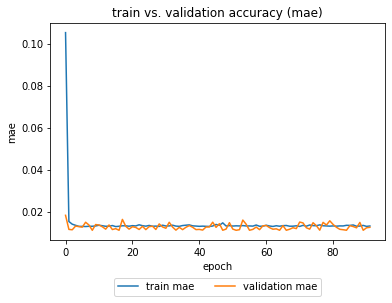

Training time was 265.66 [s].



In [19]:
"""startTime = time.time()
# 8 window sliding model fit 
model8 = define_model(X_8, y_8)
model8, X_train_8_mae, X_val_8_mae = train_model(X_8, y_8, model8)
plot_mae(X_train_8_mae, X_val_8_mae)
print(f'Training time was {time.time() - startTime:.2f} [s].\n')"""

"""startTime = time.time()
# 16 window sliding model fit
model16 = define_model(X_16, y_16)
model16, X_train_16_mae, X_val_16_mae = train_model(X_16, y_16, model16)
plot_mae(X_train_16_mae, X_val_16_mae)
print(f'Training time was {time.time() - startTime:.2f} [s].\n')"""

"""startTime = time.time()
# 32 window sliding model fit
model32 = define_model(X_32, y_32)
model32, X_train_32_mae, X_val_32_mae = train_model(X_32, y_32, model32)
plot_mae(X_train_32_mae, X_val_32_mae)
print(f'Training time was {time.time() - startTime:.2f} [s].\n')"""

"""
startTime = time.time()
# 120 window sliding model fit
model64 = define_model(X_64, y_64)
model64, X_train_64_mae, X_val_64_mae = train_model(X_64, y_64, model64)
plot_mae(X_train_64_mae, X_val_64_mae)
print(f'Training time was {time.time() - startTime:.2f} [s].\n')"""

startTime = time.time()
# 120 window sliding model fit
model50 = define_model(X_50, y_50)
model50, X_train_50_mae, X_val_50_mae = train_model(X_50, y_50, model50)
plot_mae(X_train_50_mae, X_val_50_mae)
print(f'Training time was {time.time() - startTime:.2f} [s].\n')

In [20]:
def preprocess(df:pd.DataFrame(), window:int, listSC:list(), listfeatures:list(), nullprocess:bool==True, logprocess:bool==True):
    df_copy = df.copy()
    X = []
    
    for sc in tqdm(listSC):
        dfTemp = df_copy[df_copy.SecuritiesCode == sc]
        
        dfTemp[listfeatures] = dfTemp[listfeatures].apply(np.log1p)
        dfTemp[listfeatures] = scaler.transform(dfTemp[listfeatures])
        
        dfTemp = dfTemp.interpolate()
        dfTemp = dfTemp.bfill().ffill()
        #dfTemp = dfTemp.fillna(0)
        
        #dfTemp = dfTemp.tail(window)
        x = dfTemp[listfeatures].to_numpy()
        X.append(x)
    
    X = np.array(X)
    
    return X

def predict_rank(X, model, sample_prediction:pd.DataFrame(), listSC:list()):
    X_copy = X.copy()
    
    sample_prediction['Prediction'] = model.predict(X_copy)
    
    sample_prediction = sample_prediction.sort_values(by = 'Prediction', ascending = False)
    
    sample_prediction.Rank = np.arange(len(sample_prediction))
    
    sample_prediction = sample_prediction.sort_values(by = 'SecuritiesCode', ascending = True)
    submission = sample_prediction[['Date', 'SecuritiesCode', 'Prediction', 'Rank']]
   
    return submission

In [21]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [22]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    prices = prices[['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor']]
    prices['Date'] = pd.to_datetime(prices['Date'])
    print(prices)
    prices = get_Indicator(prices, calculate_adjusted)
    
#    X_prices_8 = preprocess(prices, 8, listSC, listfeatures, True, True)
#    X_prices_16 = preprocess(prices, 16, listSC, listfeatures, True, True)
#    X_prices_32 = preprocess(prices, 32, listSC, listfeatures, True, True)
#    X_prices_64 = preprocess(prices, 64, listSC, listfeatures, True, True)
    X_prices_50 = preprocess(prices, 50, listSC, listfeatures, True, True)

#    submission_prediction_df8 = predict_rank(X_prices_8, model8, sample_prediction, listSC)
#    submission_prediction_df16 = predict_rank(X_prices_16, model16, sample_prediction, listSC)
#    submission_prediction_df32 = predict_rank(X_prices_32, model32, sample_prediction, listSC)
#    submission_prediction_df64 = predict_rank(X_prices_64, model64, sample_prediction, listSC)
    submission_prediction_df50 = predict_rank(X_prices_50, model50, sample_prediction, listSC)

#    sample_prediction.Prediction = (submission_prediction_df8.Prediction + submission_prediction_df16.Prediction + submission_prediction_df32.Prediction) / 3
    
#    sample_prediction.Prediction = submission_prediction_df16.Prediction
    sample_prediction.Prediction = submission_prediction_df50.Prediction
    
    sample_prediction = sample_prediction.sort_values(by = 'Prediction', ascending = False)
    
    sample_prediction.Rank = np.arange(len(sample_prediction))

    sample_prediction = sample_prediction.sort_values(by = 'SecuritiesCode', ascending = True)
    sample_prediction_copy = sample_prediction[['Date','SecuritiesCode','Prediction','Rank']]
    sample_prediction_copy = sample_prediction_copy.fillna(0.0)
    
    sample_prediction = sample_prediction[['Date', 'SecuritiesCode','Rank']]
    
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
           Date  SecuritiesCode    Open    High     Low   Close   Volume  \
0    2021-12-06            1301  2982.0  2982.0  2965.0  2971.0     8900   
1    2021-12-06            1332   592.0   599.0   588.0   589.0  1360800   
2    2021-12-06            1333  2368.0  2388.0  2360.0  2377.0   125900   
3    2021-12-06            1375  1230.0  1239.0  1224.0  1224.0    81100   
4    2021-12-06            1376  1339.0  1372.0  1339.0  1351.0     6200   
...         ...             ...     ...     ...     ...     ...      ...   
1995 2021-12-06            9990   528.0   531.0   516.0   517.0    65300   
1996 2021-12-06            9991   796.0   800.0   785.0   785.0    29100   
1997 2021-12-06            9993  1645.0  1653.0  1627.0  1627.0     6200   
1998 2021-12-06            9994  2394.0  2433.0  2393.0  2418.0     7800   
1999 2021-12-06            9997   702.0

100%|██████████| 2000/2000 [00:10<00:00, 185.39it/s]


           Date  SecuritiesCode    Open    High     Low   Close   Volume  \
0    2021-12-07            1301  2998.0  3065.0  2990.0  3065.0    19100   
1    2021-12-07            1332   569.0   569.0   535.0   556.0  6449200   
2    2021-12-07            1333  2382.0  2417.0  2371.0  2409.0   127300   
3    2021-12-07            1375  1227.0  1266.0  1227.0  1264.0   128600   
4    2021-12-07            1376  1374.0  1395.0  1366.0  1395.0     5800   
...         ...             ...     ...     ...     ...     ...      ...   
1995 2021-12-07            9990   526.0   535.0   524.0   535.0    57800   
1996 2021-12-07            9991   795.0   806.0   792.0   805.0    48500   
1997 2021-12-07            9993  1640.0  1640.0  1620.0  1620.0     6600   
1998 2021-12-07            9994  2437.0  2440.0  2423.0  2440.0     5200   
1999 2021-12-07            9997   711.0   719.0   706.0   719.0   204500   

      AdjustmentFactor  
0                  1.0  
1                  1.0  
2           

100%|██████████| 2000/2000 [00:10<00:00, 187.12it/s]


In [23]:
sample_prediction_copy.isnull().sum()

Date              0
SecuritiesCode    0
Prediction        0
Rank              0
dtype: int64

In [24]:
sample_prediction_copy.head()

,Date,SecuritiesCode,Prediction,Rank
0,2021-12-07,1301,0.007619,1470
1,2021-12-07,1332,0.007835,160
2,2021-12-07,1333,0.007644,1264
3,2021-12-07,1375,0.007728,624
4,2021-12-07,1376,0.007711,727


In [25]:
score1 = calc_spread_return_sharpe(sample_prediction_copy, portfolio_size = 200, toprank_weight_ratio = 2)
print(score1)
    
#score2 = cal_sharpe_ratio(sample_prediction_copy)
#print(score2)

nan


In [26]:
#score1 = calc_spread_return_sharpe(sample_prediction_copy, portfolio_size = 200, toprank_weight_ratio = 2)
#print(score1)

In [27]:
#score2 = cal_sharpe_ratio(sample_prediction_copy)
#print(score2)

In [28]:
sample_prediction

,Date,SecuritiesCode,Rank
0,2021-12-07,1301,1470
1,2021-12-07,1332,160
2,2021-12-07,1333,1264
3,2021-12-07,1375,624
4,2021-12-07,1376,727
...,...,...,...
1995,2021-12-07,9990,130
1996,2021-12-07,9991,310
1997,2021-12-07,9993,893
1998,2021-12-07,9994,1306
